In [1]:
%matplotlib inline
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# import matplotlib
# import torch
# import torch vision


# Lowes Computer Vision Workshop 
**Author**: [Elizabeth Johnson](https://egjohnson.github.io)
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

# A future statement is a directive to the compiler 
# that a particular module should be compiled using syntax or semantics 
# that will be available in a specified future release of Python. 

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Think of cuDNN as a library for Deep Learning using CUDA 
# and CUDA as a way to talk to the GPU.
# cudnn.benchmark enables benchmark mode in cudnn.
# benchmark looks for the optimal set of algorithms for 
# that particular configuration. This usually leads to faster runtime.
# Only turn on benchmark mode whenever your input sizes for your network do not vary. 
# otherwise the algorithm will try to reoptimize at every iteration.

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



In [6]:

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


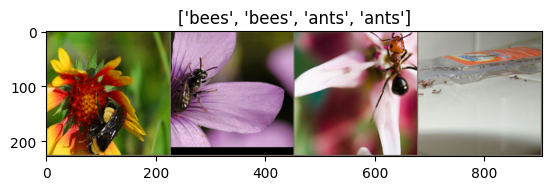

In [11]:

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """function returns trained pytorch model object"""
    since = time.time()
    # weights are being copied from the pre-trained pytorch model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
     
    # an epoch signifies when all the training data has passed through the net
    # the number of epochs is how many times you want to pass the data
    # through the net
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each Epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            # EP0. reset model to appropriate mode
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # EP1. pass net over all batches of data.
            for inputs, labels in dataloaders[phase]:
                # A. set up pass 
                inputs = inputs.to(device)
                labels = labels.to(device)

                #zero the parameter gradients
                optimizer.zero_grad()

                # B. forward pass of net over data
                with torch.set_grad_enabled(phase == 'train'):
                    # b1. run net on batch of images 
                    outputs = model(inputs)
                    # b2. check how well model did
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # b3. based on how model did on this pass, optimize next pass
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # C. append statistics from pass
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # EP2. if in training phase, move optimizer to its next step
            if phase == 'train':
                scheduler.step()
            
            # EP3. Figure out how well the net classified the objects this epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # EP4. update the weights if this epochs weights were more accurate on the validation set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'model says: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## setting up the convnet training

1. Load a pretrained model 
2. reset final fully connected layer.
3. Choose how model outputs will be penalized.
 - https://365datascience.com/tutorials/machine-learning-tutorials/cross-entropy-loss/
 - https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
4. Choose your optimizer and what parts of the net you wish to optimize
5. train set up: Decay Learning Rate (LR) by a factor of 0.1 every 7 epochs


In [14]:

# TorchVision offers pre-trained weights for every provided architecture,
# using the PyTorch torch.hub. Instancing a pre-trained model 
# will download its weights to a cache directory.

# 1. create model from pytorch's pretrained models 
model_ft = models.resnet18(pretrained=True)
#record in_feature (the number of inputs for your linear layer)
# fc stands for fully connected layer
num_ftrs = model_ft.fc.in_features
# 2. reset fully connected linear layer, set the number of outputs to 2 classes
model_ft.fc = nn.Linear(num_ftrs, 2)
# send the model to your device (either CPU or GPU)
model_ft = model_ft.to(device)
# 3. choose how will penalize model 
criterion = nn.CrossEntropyLoss()
# 4. choose what parts of the net to optimize: all 
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# 5. train set up: Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/elizajoh/NewGits/wids_2023_workshop/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/elizajoh/NewGits/wids_2023_workshop/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5497 Acc: 0.6885
val Loss: 0.3860 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.6449 Acc: 0.7377
val Loss: 0.2862 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.3111 Acc: 0.8402
val Loss: 0.1972 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3402 Acc: 0.8811
val Loss: 0.4287 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5747 Acc: 0.7787
val Loss: 0.6083 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.3482 Acc: 0.8238
val Loss: 0.2102 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5734 Acc: 0.7787
val Loss: 0.4066 Acc: 0.8497

Epoch 7/24
----------
train Loss: 0.3673 Acc: 0.8238
val Loss: 0.2127 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3991 Acc: 0.8279
val Loss: 0.2062 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3564 Acc: 0.8770
val Loss: 0.1981 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2828 Acc: 0.9016
val Loss: 0.1667 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2921 Acc: 0.8811
val Loss: 0.1546 Acc: 0.9346

Ep

In [1]:
visualize_model(model_ft)

NameError: name 'visualize_model' is not defined

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [ ]:
model_conv = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# gamma: describes how quickly you want the optimizer to start slowing down
# step_size: optimizer deaccelerates every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()